## Unet Practice

In this exercise, we will implement an image segmentation pipeline to identify the boundary between land and sea in coastal images using a U-Net architecture.

We will train a deep learning model based on U-Net to perform binary segmentation on aerial images of coastal regions. The goal is to produce a mask that highlights the coastline.


### Network definition

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetMini(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetMini, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)

     

        # Output
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # Decoder
       

        # Output
        return F.sigmoid(self.out_conv(d1))


### Data preparation

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.transform = transform
        self.target_transform = target_transform

        self.img_filenames = sorted(os.listdir(self.img_dir))
        self.mask_filenames = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


In [4]:
# Transforms per a la imatge (normalització i augmentació si vols)
img_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transforms per a la màscara (només resize i conversió a tensor)
mask_transforms = T.Compose([
    T.Resize((128, 128), interpolation=Image.NEAREST),
    T.ToTensor(),
])

# Crear dataset i DataLoader
dataset = SegmentationDataset(root_dir='../data/coastline',
                               transform=img_transforms,
                               target_transform=mask_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divisió
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders per a cada conjunt
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


### Train

In [29]:
import torch.optim as optim
from tqdm.auto import tqdm
epochs = 15
model = UNetMini()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

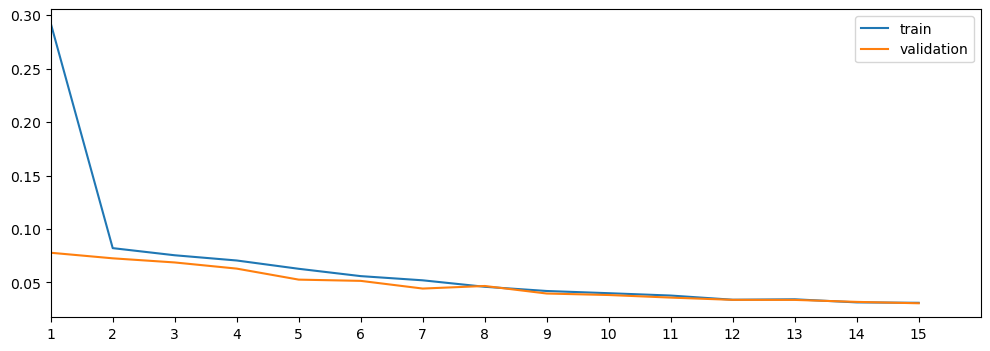

In [30]:
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl


running_loss = []
running_val_loss = []

pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:

    model.train()  # Posam el model a mode entranament.
    batch_loss = 0
    for i_batch, (x, y) in enumerate(train_loader):

        # 1. PREDICCIÓ
        y_pred = model(x)

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = F.binary_cross_entropy(y_pred, y)
        loss.backward()
        
        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()
        #3. GRADIENT
        optimizer.zero_grad()

        batch_loss += loss.detach().numpy()
    running_loss.append(batch_loss / len(train_loader))

    batch_test_loss = 0
    batch_test_acc = 0
    
    model.eval()
    for i_batch, (x, y) in enumerate(val_loader):
        
        y_pred = model(x)        
        batch_test_loss +=  F.binary_cross_entropy(y_pred, y).detach().numpy()

    running_val_loss.append(batch_test_loss / (len(val_loader)))
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(running_loss[:epoch], label="train")
    pl.plot(running_val_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0, epochs, 1), range(1, epochs + 1, 1))

    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{running_loss[epoch-1]} Validation Loss:{running_val_loss[epoch-1]}")

## Evaluation

Your task is to run inference process with the U-Net model. That means using the model on the test set to get the segmentation  masks that highlight the areas of interest. Run the model, and look at the output masks to see what the model has detected.

**Extra**

Load an image from internet and observe the results

In [ ]:
#model.eval()

In this second stage we will compute the IOU on the train set and we will compare it with the results from the test set.